### Required Packages

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cyvcf2 import VCF
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, auc

# Parse VCF 

## Extract and Format Variant Information

In [2]:
def parse_csq(fields, csq_str):
    csq = []
    annotation_list = csq_str.split(",")
    for annotation in annotation_list:   
        csq.append(dict(zip(fields, annotation.split("|"))))
        return csq

def extract_csq_keys(parsed_csq, keys):
    annos = []
    values = []
    
    for anno in parsed_csq:
        for item in anno.items():
            if item[0] in keys:
                annos.append(item[0])
                values.append(item[1])
    return dict(zip(annos, values))    

def extract_info_keys(info_field, keys):
    annos = []
    values = []
    
    for key in keys:
        annos.append(key)
        values.append(info_field.get(key, ""))
        
    return dict(zip(annos, values))

def parse_vcf(path_to_vcf):
    vcf = VCF(path_to_vcf)
    csq_fields = vcf.get_header_type("CSQ")["Description"][51:-1].split("|")
    data = []
    for variant in vcf:
        chrom = variant.CHROM
        pos = variant.POS
        ref = variant.REF
        alt = variant.ALT[0] if len(variant.ALT) else ""
        filter_value = variant.FILTER
        
        info = variant.INFO
        #info_keys = ["CSQ", "RankResult", "RankScore", "CLNSIG", "AF", "DP", "GNOMAD_AF"]
        # extract INFO-keys
        info_keys = extract_info_keys(info, keys=["CSQ", "RankResult", "RankScore", "CLNSIG", "AF", "DP", "GNOMAD_AF"]) 
        
        #csq_str = info.get("CSQ", "") 
        af, pp, con, vcqf, lin, clin = [float(x) for x in info_keys.get("RankResult", "0|0|0|0|0|0").split("|")]   
        rank_score = float(info_keys.get("RankScore").split(":")[1])   
        clnsig = info_keys.get("CLNSIG", "") 
        vaf = info_keys.get("AF", "")
        coverage = info_keys.get("DP", "")

        # Parse CSQ 
        csq = parse_csq(csq_fields, info_keys.get("CSQ", ""))
        csq_keys = extract_csq_keys(csq, keys = ["Consequence", "SIFT", "PolyPhen", "gnomAD_AF", "COSMIC", "CLIN_SIG"])


        # Format strings for extracting controls
        chrom_pos = f"{chrom}_{pos}"
        ref_alt = f"{ref}_{alt}"
        
        data.append({
            "VARIANT": f"{chrom_pos}_{ref_alt}",
            "CHROM_POS": chrom_pos,
            "AF": af,
            "PP": pp,
            "CON": con,
            "VCQF": vcqf,
            "LIN": lin,
            "CLIN": clin,
            "CLNSIG": clnsig,
            "RANK_SCORE": rank_score,
            #"parsed_csq": csq,
            #"csq_key": csq_keys,
            #"Consequence": csq_keys.get("Consequence", ""), 
            #"SIFT": csq_keys.get("SIFT", ""), 
            #"PolyPhen": csq_keys.get("PolyPhen", ""), 
            #"gnomAD_AF": csq_keys.get("gnomAD_AF", ""), 
            #"COSMIC": csq_keys.get("COSMIC", ""), 
            #"CLIN_SIG": csq_keys.get("CLIN_SIG", ""),
            #"FILTER": filter_value,
            #"VAF(AF)": vaf,
            #"COVERAGE(DP)": coverage
        })
    return pd.DataFrame(data)

# Process Data

## Group Variants, Adjust Score and Mark Controls

In [4]:
GROUPS_WITH_LABELS = {
    "benign": ['Benign',
               'Likely_benign',
               'Benign/Likely_benign',
               'Benign|drug_response',
               'Likely_benign|other',
               'Likely_benign|drug_response|other'],
    "pathogenic": ['Pathogenic',
                   'Pathogenic/Likely_pathogenic',
                   'Pathogenic|other',
                   'Likely_pathogenic',
                   'Likely_pathogenic|association',
                   'Pathogenic/Likely_pathogenic|risk_factor',
                  'Pathogenic|drug_response'],
    "uncertain": ['Conflicting_classifications_of_pathogenicity',
                  'Conflicting_classifications_of_pathogenicity|drug_response|other',
                  'Conflicting_classifications_of_pathogenicity|association',
                  'Uncertain_significance'],
    "other": ['', 'not_provided', 'drug_response']
}

def group_variants(df, from_col="CLNSIG", groups=GROUPS_WITH_LABELS, to_col="GROUP"):
    """ 
    Groups variants by 'groups' based on information in 'from_col'.
    Adjusts RANK_SCORE by subtracting CLIN Score to mitigate bias.
    Args:
    df (pd.DataFrame): data with variants to group
    from_col (str): the column in df to use for grouping (required in df)
    to_col (str): the name of the new column that will contain variant group labels
    Returns:
    df (pd.DataFrame): the df extended with 'to_column' values and 'ADJUSTED_SCORE'. 
    """
    df[from_col] = df[from_col].str.strip()
    
    def classify(clnsig):
        for group, labels in groups.items():
            if clnsig in labels:
                return group
        print(f"Unmatched CLNSIG value: {clnsig}")  # Log unmatched values
        return "other"  # Return original label if no match is found

    # Apply the classification logic to the DataFrame
    df[to_col] = df[from_col].apply(classify)
    
    df["ADJUSTED_SCORE"] = df["RANK_SCORE"] - df["CLIN"]
    
    return df

def mark_controls(df, controls="data/controls_match.tsv"):
    c = pd.read_csv(controls, sep="\t")
    control_set = set(c["chrom_pos"])
    df["IS_CONTROL"] = df["CHROM_POS"].isin(control_set)
    return df

# Analyze Data
## Extract and Process Data
1. SNV.somatic.sweetelf.merged.clinical.ranked.vcf.gz
   validation dataset including HD829 positive controls
3. snvs_only.scored.vcf
   variants with "Pathogenic" or "Benign" CLNSIG values &&
   with high-confidence review statuses &&
   filtered for SNVs only.

In [5]:
vcf_file_path = "data/SNV.somatic.sweetelf.merged.clinical.ranked.vcf.gz"
clinvar_path = "data/snvs_only.scored.vcf"

# read VCF file into a pandas Dataframe 
df_hd829 = parse_vcf(vcf_file_path) 
df_clinvar = parse_vcf(clinvar_path)

# Group variants
df_hd829 = group_variants(df_hd829.copy())
df_clinvar = group_variants(df_clinvar.copy())

# Mark controls
df_hd829 = mark_controls(df_hd829)


# Extended Dataset
A subset (ask Mathias) of ClinVar.vcf latest was cleaned from prior annotations before the Balsamic annotation and scoring workflow was applied. 
This VCF contained ~51222 scored variants. 

Because ClinVar contains various annotations not specific to cancer, the dataset was filtered to align with this project aim. 

## Filter SNVs with CLNSIG values "Pathogenic" or "Benign" and Review Status
To extract only variants annotated (CLNSIG) as "Pathogenic" or "Benign" the following command was used. 
    
    grep -E "^#|CLNSIG=.*(Pathogenic|Benign)" input.vcf > filtered_clinvar.vcf
    
^#: Keeps the header lines.
CLNSIG=.*(Pathogenic|Benign): Matches INFO lines where CLNSIG contains "Pathogenic" or "Benign".

In order to get best possible quality variants, the filtered dataset was filtered by Review Status "expert panel" or "practice guideline". To achieve this, the following command was used: 

    grep -E "^#|CLNREVSTAT=.*(expert_panel|practice_guideline)" filtered_clinvar.vcf > high_confidence.vcf

CLNREVSTAT=.*(expert_panel|practice_guideline): Matches variants with high-confidence review statuses.

Finally, the dataset was filtered to only retain SNVs in order to be representative for this project. SNVs (Single Nucleotide Variants) can be identified where the REF and ALT columns are single bases (e.g., A, C, G, T). To filter such rows awk was used: 

    awk 'BEGIN {OFS="\t"} /^#/ {print $0} !/^#/ && length($4) == 1 && length($5) == 1 {print $0}' high_confidence.vcf > snvs_only.vcf

/^#/: Retains header lines.
length($4) == 1 && length($5) == 1: Ensures both REF (column 4) and ALT (column 5) are single bases.

## Verify Output
To verify the generated files by counting the lines in each file:

    wc -l input.vcf filtered_clinvar.vcf high_confidence.vcf snvs_only.vcf

* filtered_clinvar.vcf: Variants with "Pathogenic" or "Benign" CLNSIG values.
* high_confidence.vcf: Subset with high-confidence review statuses.
* snvs_only.vcf: Further filtered for SNVs only.

## Assess Class Distribution 
Determine the number and percentage of benign and pathogenic variants.

Class Distribution:
GROUP
pathogenic    3230
benign        2203
Name: count, dtype: int64

Class Percentage:
GROUP
pathogenic    59.4515
benign        40.5485
Name: proportion, dtype: float64

The dataset is balanced.


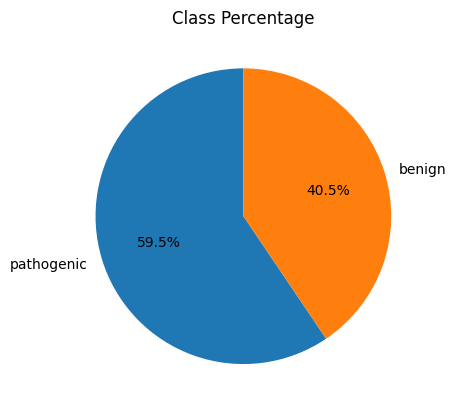

In [6]:
def assess_distribution(df, label_col):
    class_distribution = df[label_col].value_counts()
    class_percentage = df[label_col].value_counts(normalize=True) * 100 # With normalize set to True , returns the relative frequency by dividing all values by the sum of values.
    
    print("Class Distribution:")
    print(class_distribution)
    print("\nClass Percentage:")
    print(class_percentage)

    # Imbalance check
    imbalance_threshold = 80
    if any(class_percentage > imbalance_threshold):
        print("\nThe dataset is imbalanced.")
    else:
        print("\nThe dataset is balanced.")


    # Pie chart
    class_distribution.plot(kind="pie", autopct="%1.1f%%", startangle=90)
    plt.title("Class Percentage")
    plt.ylabel("")
    plt.savefig("class_distribution.png", dpi=100)
    plt.show()
# Example usage 
assess_distribution(df_clinvar, "GROUP")

# Analysis

## Scatter Plot With Controls By Group
- Get an overview of the score distribution accross groups
  - each group has unique color
  - controls are higlighted
- Identify potential patterns, such as clusters or outliers
  - Use jitter to avoid overlapping points


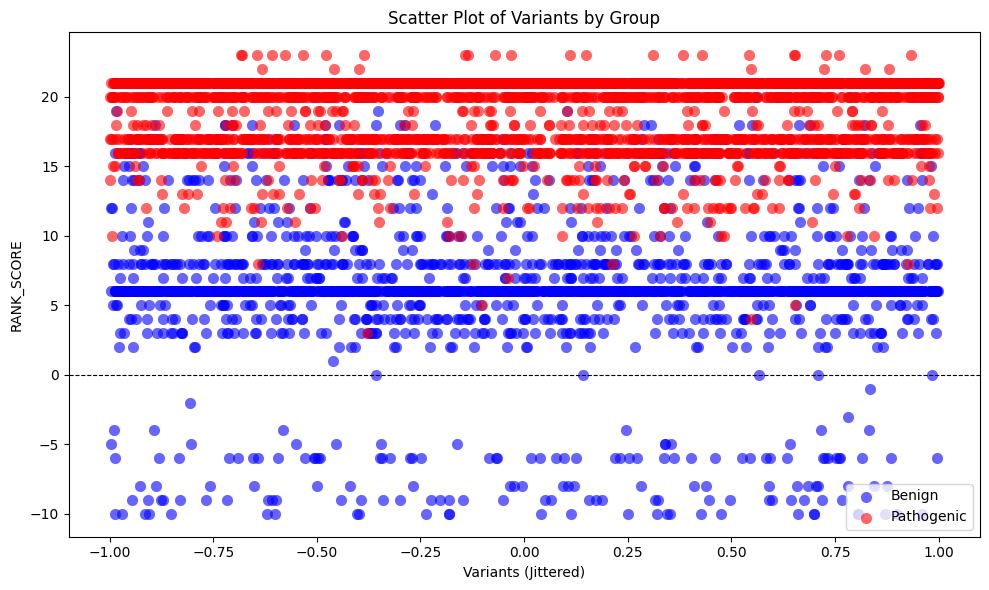

In [7]:
# Scatter Plot Groups
def plot_scatter_with_controls(df, score_col="RANK_SCORE", group_col="GROUP", control_col="IS_CONTROL"):
    """
    Creates a scatter plot with jitter, coloring by group, and highlighting controls.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - score_col (str): Column for the score to plot on the y-axis.
    - group_col (str): Column for the groups to color points.
    - control_col (str): Column indicating control variants (boolean).
    """
    # Generate jitter for x-axis
    jitter = np.random.uniform(-1.0, 1.0, size=len(df))

    # Assign colors for groups
    group_colors = {
        "benign": "blue",
        "pathogenic": "red",
        "other": "gray",
        "uncertain": "orange",
    }

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    for group, color in group_colors.items():
        subset = df[df[group_col] == group]
        plt.scatter(
            x=jitter[subset.index],
            y=subset[score_col],
            s=60,
            label=group.capitalize() if not subset.empty else None,
            color=color,
            alpha=0.6,
            edgecolor="black" if control_col in subset.columns else None,
            linewidth=0.2,
        )
    
    # Highlight controls
    if control_col in df.columns:
        controls = df[df[control_col]]
        plt.scatter(
            x=jitter[controls.index],
            y=controls[score_col],
            facecolors="#9AFF60",
            edgecolors="black",
            label="Control",
            s=120,
        )

    # Plot formatting
    plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
    plt.xlabel("Variants (Jittered)")
    plt.ylabel(score_col)
    plt.title("Scatter Plot of Variants by Group")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig("scatter_by_group.png")
    plt.show()

# Call the function
plot_scatter_with_controls(df_clinvar)

## Reduce Noice and Focus on Benign and Pathogenic Groups
- Retain rows where the GROUP is either Benign or Pathogenic
- Calculate adjusted score (RANK_SCORE - CLIN)
- visualize separatione between Benign and Pathogenic groups by ADJUSTED_SCORE in a violin plot
- visualize ADJUSTED_SCORE distribution in a density plot


### Step 1 & 2: Filter and Adjust Scores
{'Total Rows': 1381, 'Group Counts': {'benign': 1342, 'pathogenic': 39}, 'Adjusted Score Range': (-17.0, 15.0)}


In [8]:
# Step 1: Filter for Benign and Pathogenic groups
filtered_df = df_clinvar[df_clinvar['GROUP'].isin(['benign', 'pathogenic'])].copy()

# Step 2: Calculate ADJUSTED_SCORE
#filtered_df['ADJUSTED_SCORE'] = (filtered_df['RANK_SCORE'] - filtered_df['CLIN'])

# Summarize the filtered dataset
filtered_summary = {
    "Total Rows": filtered_df.shape[0],
    "Group Counts": filtered_df['GROUP'].value_counts().to_dict(),
    "Adjusted Score Range": (filtered_df['ADJUSTED_SCORE'].min(), filtered_df['ADJUSTED_SCORE'].max())
}

print(filtered_summary)

{'Total Rows': 5433, 'Group Counts': {'pathogenic': 3230, 'benign': 2203}, 'Adjusted Score Range': (-8.0, 17.0)}


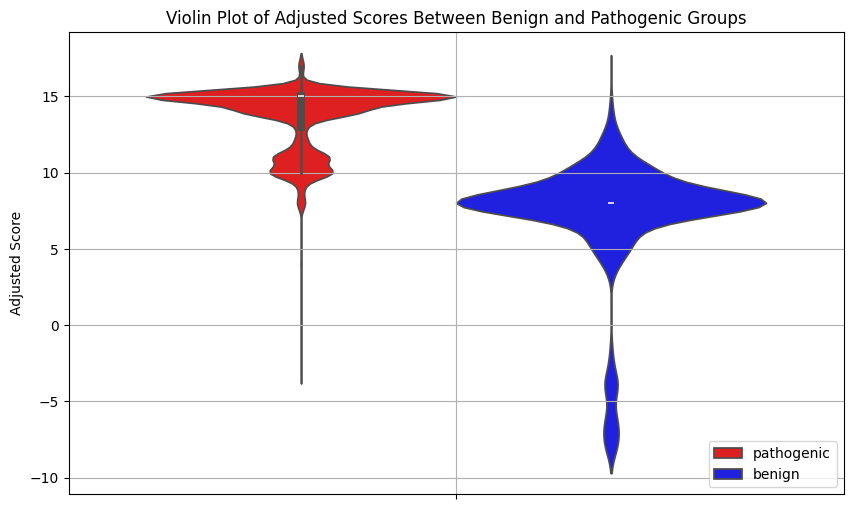

In [9]:
# Violin Plot
plt.figure(figsize=(10, 6))

palette = {"benign": "blue", "pathogenic": "red"}
sns.violinplot(
    data=filtered_df,
    hue='GROUP',
    y='ADJUSTED_SCORE',
    palette=palette
    
)
plt.title("Violin Plot of Adjusted Scores Between Benign and Pathogenic Groups")
plt.ylabel("Adjusted Score")
plt.grid()
plt.legend(loc="lower right")
plt.savefig("violin_adjusted_scores_by_group.png")
plt.show()

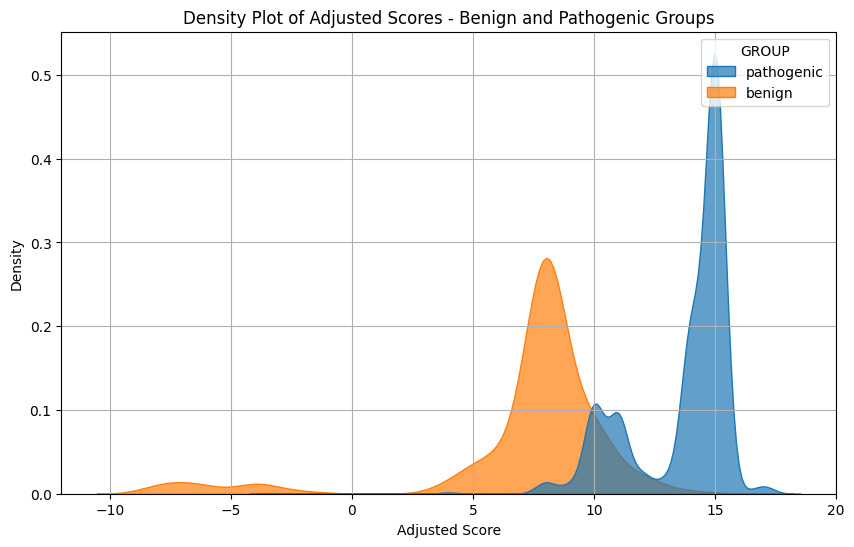

In [10]:
# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=filtered_df,
    x='ADJUSTED_SCORE',
    hue='GROUP',
    fill=True,
    common_norm=False,
    alpha=0.7
)
plt.title("Density Plot of Adjusted Scores - Benign and Pathogenic Groups")
plt.xlabel("Adjusted Score")
plt.ylabel("Density")
plt.grid()
plt.savefig("density_adjusted_by_group.png")
plt.show()

## Threshold Analysis
- analyze overlaps
- iterate steps for re-weighting

Optimal Threshold (Max F1-Score): 10


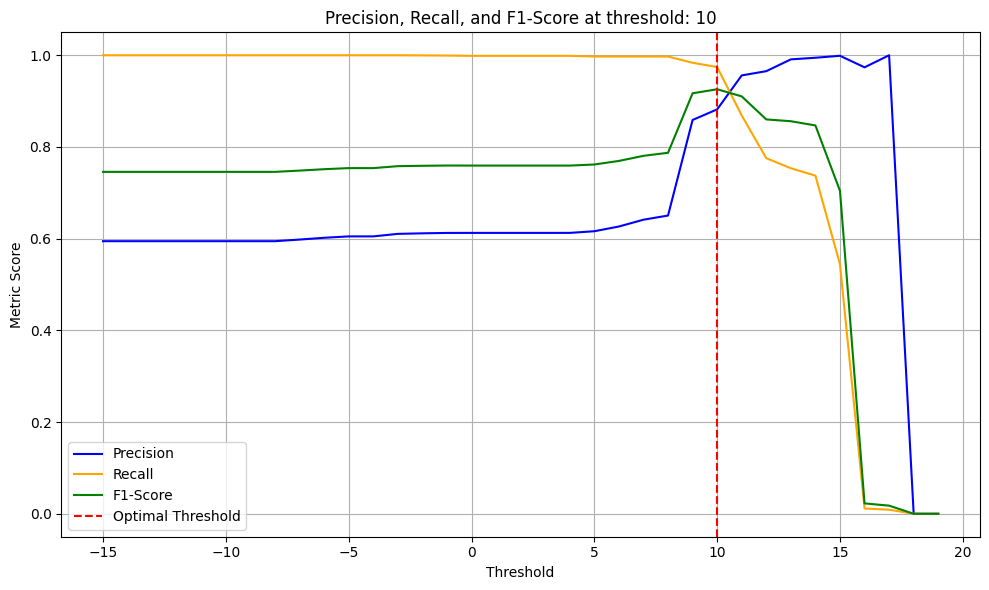

In [15]:
# Workflow 1: Threshold Analysis

# Step 1: Define a function to calculate metrics for thresholds
def calculate_metrics_by_threshold(scores, labels, thresholds):
    results = []
    for threshold in thresholds:
        y_pred = (scores >= threshold).astype(float)
        precision = precision_score(labels, y_pred, zero_division=0)
        recall = recall_score(labels, y_pred, zero_division=0)
        f1 = f1_score(labels, y_pred, zero_division=0)
        results.append({"threshold": threshold, "precision": precision, "recall": recall, "f1_score": f1})
    return pd.DataFrame(results)

# Step 2: Define a function to visualize the metrics
def visualize_metrics(metrics_df):
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df["threshold"], metrics_df["precision"], label="Precision", color="blue")
    plt.plot(metrics_df["threshold"], metrics_df["recall"], label="Recall", color="orange")
    plt.plot(metrics_df["threshold"], metrics_df["f1_score"], label="F1-Score", color="green")
    plt.axvline(metrics_df.loc[metrics_df["f1_score"].idxmax(), "threshold"], color="red", linestyle="--", label="Optimal Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Score")
    # Find the threshold with the maximum F1-Score
    optimal_threshold = metrics_df.loc[metrics_df["f1_score"].idxmax(), "threshold"]
    plt.title(f"Precision, Recall, and F1-Score at threshold: {optimal_threshold}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"threshold_analysis_threshold: {optimal_threshold}.png")
    # From the plot, select the threshold that maximizes your chosen metric.
    
    print(f"Optimal Threshold (Max F1-Score): {optimal_threshold}")
    plt.show()
   

# Step 3: Run the workflow
# Assuming `df` has the columns "ADJUSTED_SCORE" and "GROUP" with 'benign' and 'pathogenic' labels
filtered_df = filtered_df[filtered_df["GROUP"].isin(["benign", "pathogenic"])]
y_true = (filtered_df["GROUP"] == "pathogenic").astype(int)

thresholds = range(-15, 20)
# Calculate metrics
threshold_metrics = calculate_metrics_by_threshold(filtered_df["ADJUSTED_SCORE"], y_true, thresholds)

# Visualize metrics
visualize_metrics(threshold_metrics)

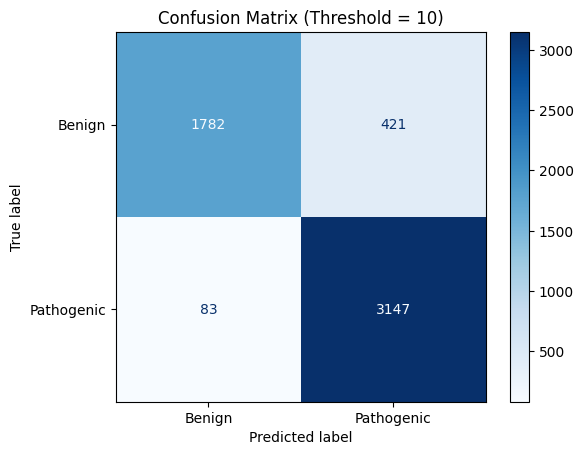

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.81      0.88      2203
  Pathogenic       0.88      0.97      0.93      3230

    accuracy                           0.91      5433
   macro avg       0.92      0.89      0.90      5433
weighted avg       0.91      0.91      0.91      5433



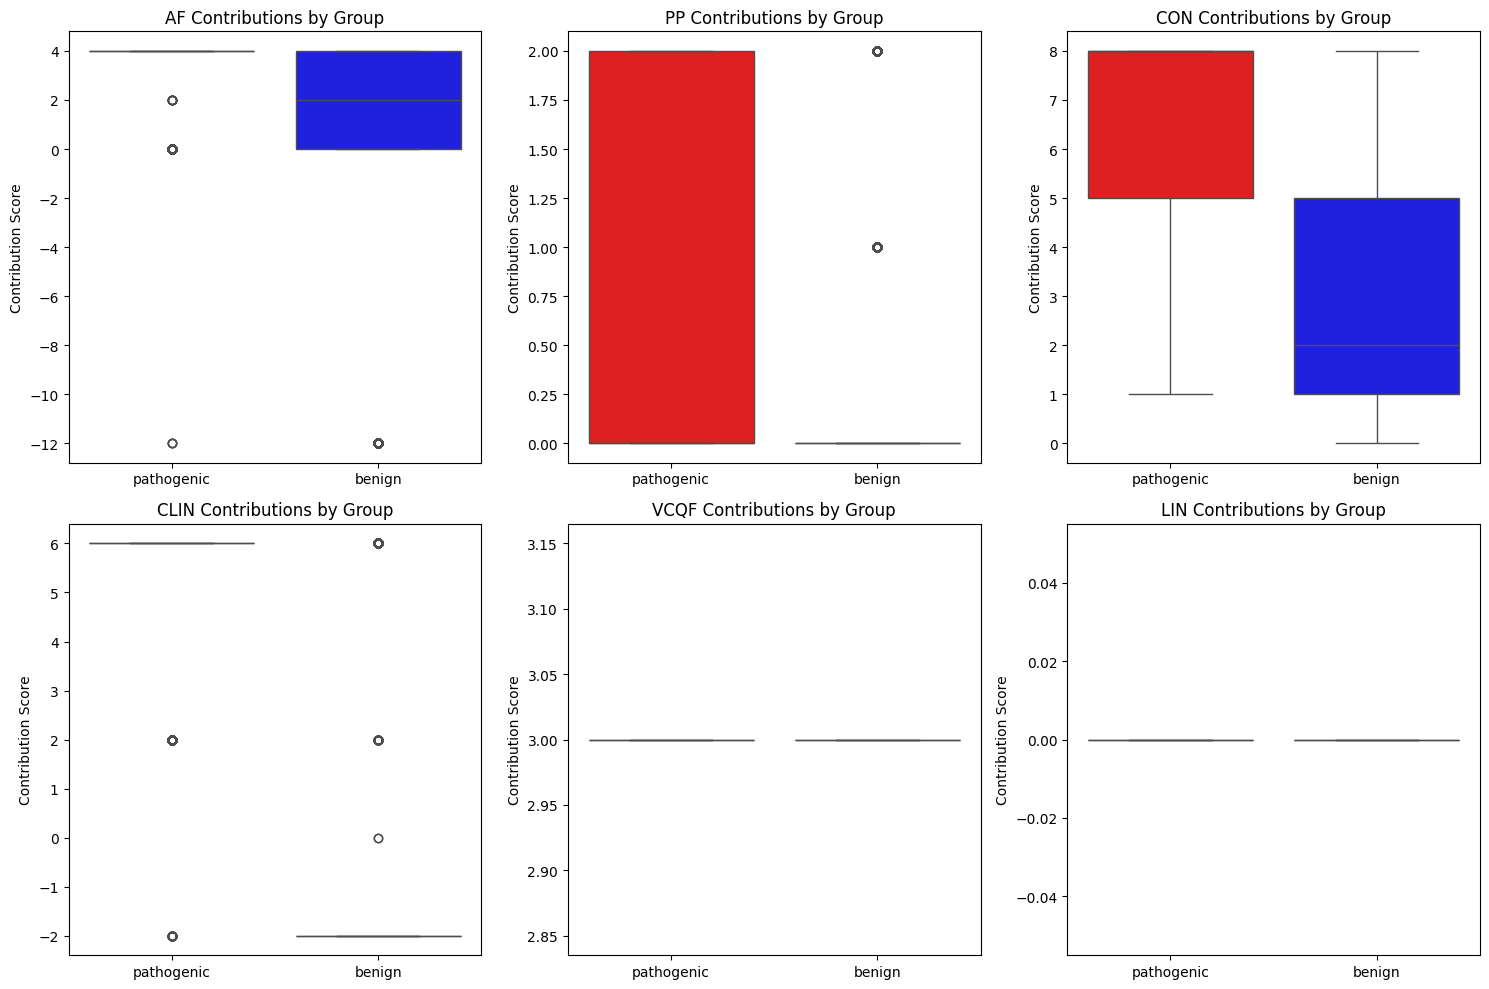

In [17]:
 
# Workflow 2: Calculate and Visualize Metrics for Optimal Threshold 


# Function to classify variants based on the optimal threshold
def classify_variants(df, threshold):
    df = df.copy()
    df['y_pred'] = (df['ADJUSTED_SCORE'] >= threshold).astype(int)
    df['y_true'] = df['GROUP'].map({'benign': 0, 'pathogenic': 1})
    return df

# Step 1: Define functions to plot the confusion matrix and feature contributions
def plot_confusion_matrix(df, threshold):
    # Classify variants
    df = classify_variants(df, threshold)
    
    # Extract true and predicted labels
    y_true = df['y_true']
    y_pred = df['y_pred']
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Pathogenic"])
    
    # Plot confusion matrix
    disp.plot(cmap='Blues', values_format='d')
    disp.ax_.set_title(f"Confusion Matrix (Threshold = {threshold})")
    
    # Save as PNG
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.savefig(f"confusion_matrix_threshold_{threshold}.png")
    plt.show()
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Pathogenic"]))
    
    return cm

def plot_feature_contributions_combined(melted_df, threshold):
    # Plot feature contributions
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=melted_df, 
        x="Feature", 
        y="Score", 
        hue="GROUP", 
        palette={"benign": "blue", "pathogenic": "red"}
    )
    plt.title(f"Feature Contributions by Group at threshold: {threshold}")
    plt.xlabel("Feature")
    plt.ylabel("Contribution Score")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.savefig(f"combined_feature_contributions_at_threshold_{threshold}.png")
    plt.show()
    
def plot_feature_contributions(df, threshold, features = ["AF", "PP", "CON", "CLIN", "VCQF", "LIN"] ):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i, feature in enumerate(features):
        row, col = divmod(i, 3)
        sns.boxplot(
            data=df,
            x="GROUP", 
            y=feature, 
            hue="GROUP",
            ax=axes[row, col], 
            palette={"benign": "blue", "pathogenic": "red"}
        )
        axes[row, col].set_title(f"{feature} Contributions by Group")
        axes[row, col].set_xlabel("")
        axes[row, col].set_ylabel("Contribution Score")
    plt.tight_layout()
    plt.savefig(f"separate_feature_contributions_at_threshold_{threshold}.png")
    plt.show()


# Step 2: Apply the optimal threshold
optimal_threshold = threshold_metrics.loc[threshold_metrics["f1_score"].idxmax(), "threshold"]
y_pred = (filtered_df["ADJUSTED_SCORE"] >= optimal_threshold).astype(int)

# Step 3: Plot the confusion matrix
plot_confusion_matrix(filtered_df, optimal_threshold)

# Melt the data for plotting feature contributions
melted_data = filtered_df.melt(
    id_vars=["GROUP"], 
    value_vars=["AF", "PP", "CON", "VCQF", "LIN", "CLIN"], 
    var_name="Feature", 
    value_name="Score"
)
# Step 4: Plot the feature contributions
#plot_feature_contributions_combined(melted_data, optimal_threshold)
plot_feature_contributions(filtered_df, optimal_threshold)

# Improvements
1. Investigate AF Overlap:
   Identfy regions of overlap between benign and pathogenic groups.
   Extreme outliers (e.g. very low or high AF values contributing incorrectly).
   Explore whether a log-transformation or binning (e.g., “low-frequency,” “moderate-frequency,” “high-frequency”) could reduce the overlap between benign and pathogenic classifications.
	2.	Focus on Key Features:
	•	Prioritize PP, CON, and AF in the model.
	•	Reduce reliance on features with minimal contributions (e.g., VCQF, LIN).
	3.	Experiment with Interactions:
	•	Test combinations of features, such as PP × CON or AF × PP, to see if they improve separation.
	4.	Use Advanced Techniques:
	•	Apply dimensionality reduction techniques like PCA (Principal Component Analysis) to capture variability while reducing noise.
	5.	Reweight Contributions:
	•	Consider assigning higher weights to features like PP and CON in the scoring algorithm to improve classification accuracy.

In [115]:
d = filtered_df["AF"]
filtered_df.head(1)

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,GROUP,ADJUSTED_SCORE,AF_log,PP_MISSING,PP_ADJUSTED,CON_AMPLIFY,CON_AMPLIFIED,CON_PP,CON_PP_CONDITIONED,WEIGHTED_CON_AF
0,1_11174395_A_G,1_11174395,4.0,2.0,5.0,3.0,0.0,6.0,Pathogenic,20.0,pathogenic,14.0,1.609438,0,2.0,5.0,5.0,10.0,0.0,13.591409


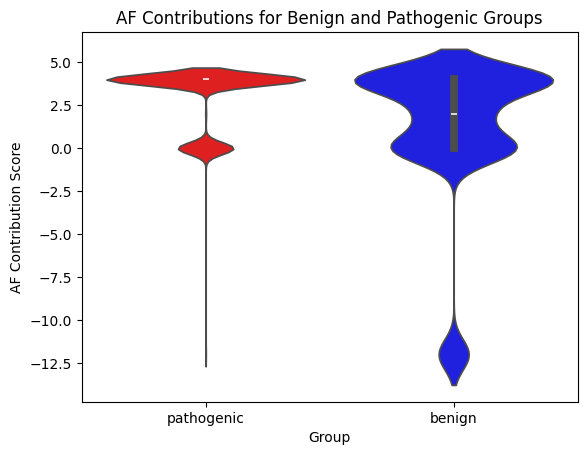

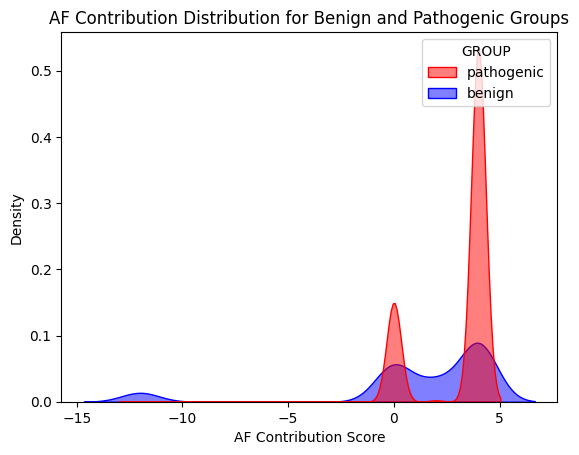

In [12]:
# Step 1: Investigate AF Overlap

# Visualize AF Contributions

def visualize_contribution(df, feature):

    # Plot feature contributions as a violin plot
    sns.violinplot(x="GROUP", hue="GROUP", y=feature, data=df, palette={"benign": "blue", "pathogenic": "red"})
    plt.title(f"{feature} Contributions for Benign and Pathogenic Groups")
    plt.ylabel(f"{feature} Contribution Score")
    plt.xlabel("Group")
    plt.savefig(f"boxplot_{feature}_contributions_by_group", dpi=100)
    plt.show()

    # Plot feature contributions as a density plot
    sns.kdeplot(data=df, x=feature, hue="GROUP", fill=True, alpha=0.5, palette={"benign": "blue", "pathogenic": "red"})
    plt.title(f"{feature} Contribution Distribution for Benign and Pathogenic Groups")
    plt.xlabel(f"{feature} Contribution Score")
    plt.ylabel("Density")
    plt.savefig(f"density_{feature}_contributions_by_group", dpi=100)
    plt.show()
visualize_contribution(filtered_df, "AF")

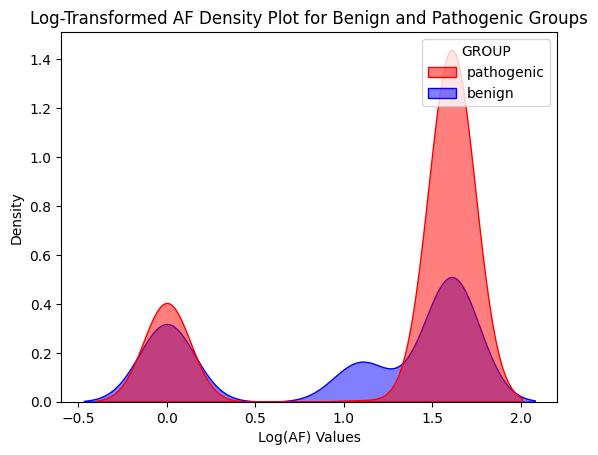

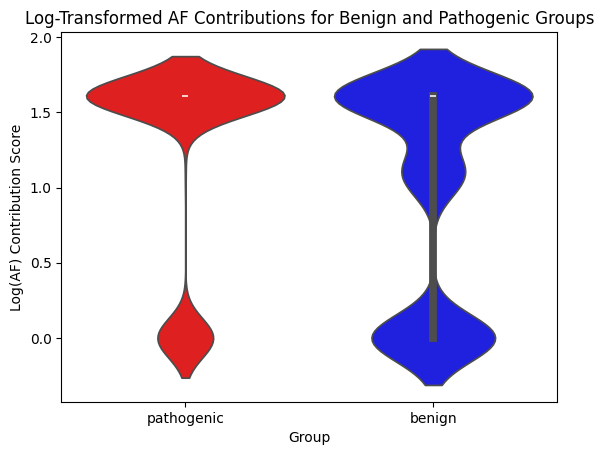

In [15]:
# Step 2: Log-Transformation of AF


palette={"benign": "blue", "pathogenic": "red"}

def visualize_contribution_log(df, feature):
    # Apply log transformation to AF (log1p ensures we handle zeros safely)
    df[f"{feature}_log"] = np.log1p(df[feature])  # log1p is log(1 + AF)
    
    # Density plot for log-transformed AF
    sns.kdeplot(data=df, x=f"{feature}_log", hue="GROUP", fill=True, alpha=0.5, palette=palette)
    plt.title(f"Log-Transformed {feature} Density Plot for Benign and Pathogenic Groups")
    plt.xlabel(f"Log({feature}) Values")
    plt.ylabel("Density")
    plt.savefig(f"log_transformed_density_{feature}_contributions_by_group", dpi=100)
    plt.show()

    # Violin plot for log-transformed AF
    sns.violinplot(x="GROUP", hue="GROUP", y=f"{feature}_log", data=df, palette=palette)
    plt.title(f"Log-Transformed {feature} Contributions for Benign and Pathogenic Groups")
    plt.ylabel(f"Log({feature}) Contribution Score")
    plt.xlabel("Group")
    plt.savefig(f"log_transformed_boxplot_{feature}_contributions_by_group", dpi=100)
    plt.show()
visualize_contribution_log(filtered_df, "AF")

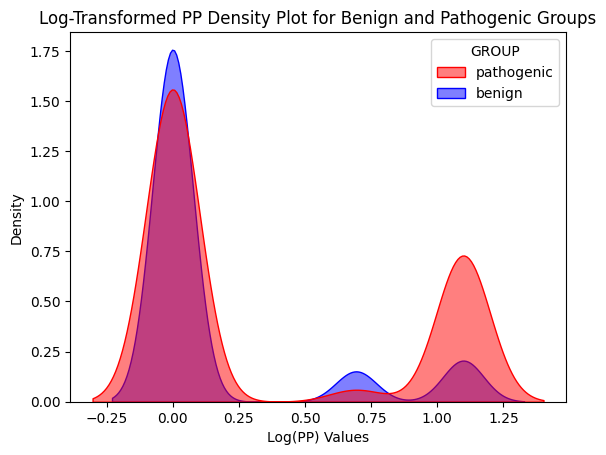

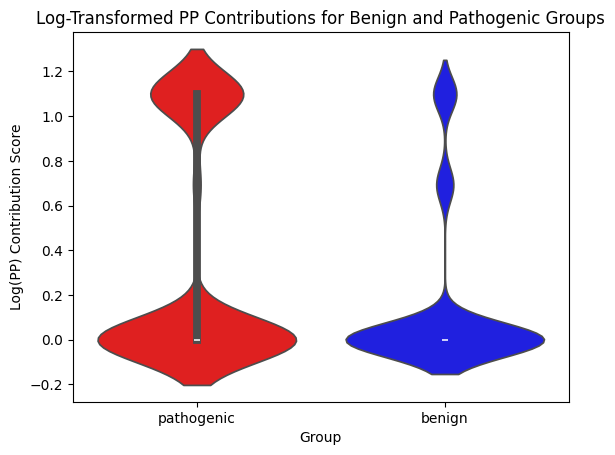

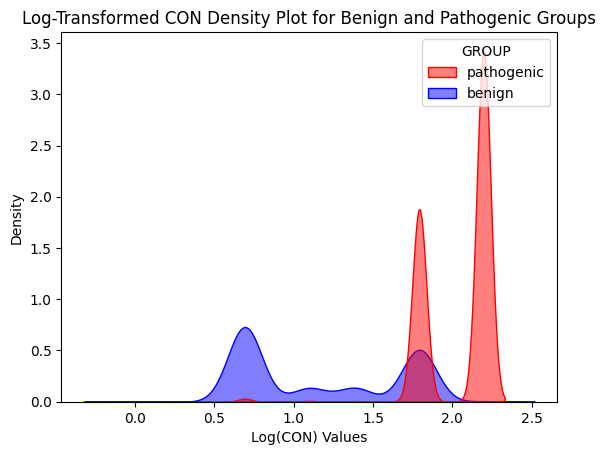

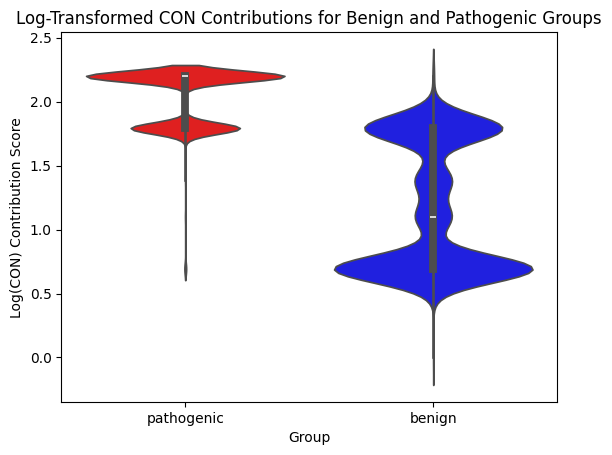

In [16]:
# Step 3: Analyze Additional Features 

visualize_contribution_log(filtered_df, "PP")
visualize_contribution_log(filtered_df, "CON")

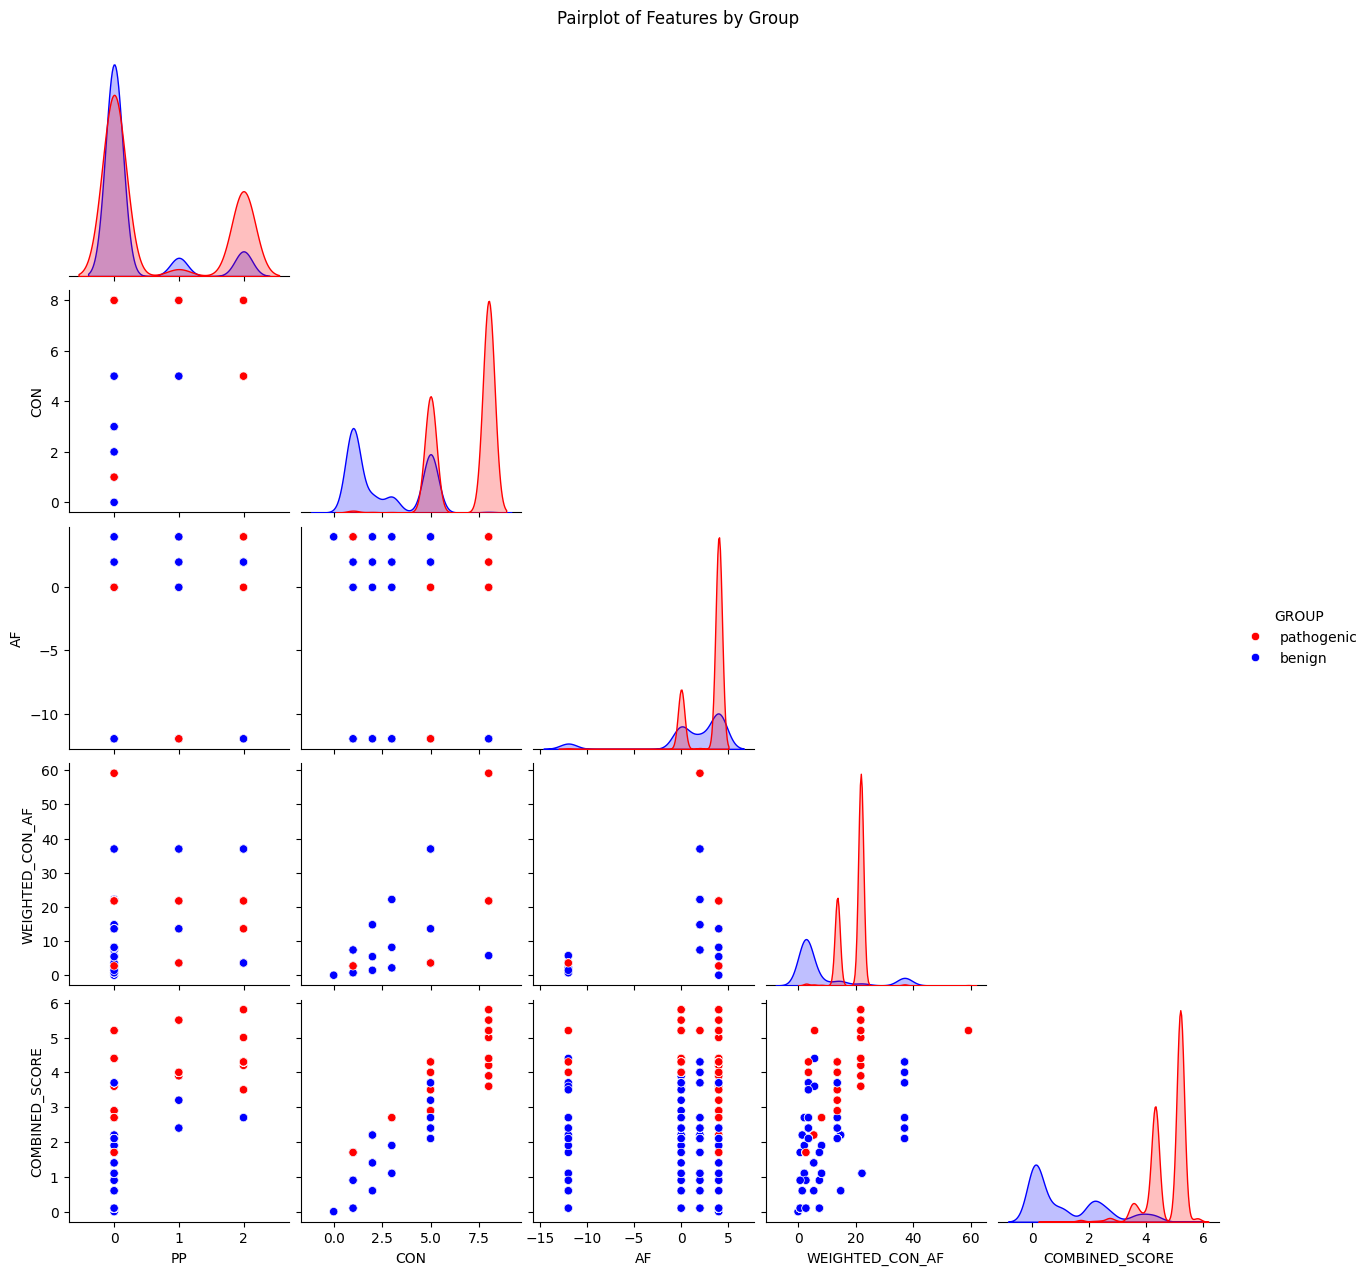

In [45]:
# Step 4: Feature Interactions

def feature_pair_plot(df):
    #features = ["PP", "CON", "AF", "WEIGHTED_CON_AF", "REWEIGHTED_CON_PP", "LOG_CON_PP", "COMBINED_SCORE"]  # Add more if necessary

    features = ["PP", "CON", "AF", "WEIGHTED_CON_AF", "COMBINED_SCORE"]  # Add more if necessary
    pairplot_data = df[features + ["GROUP"]]

    # Pairplot with hue for group differentiation
    sns.pairplot(pairplot_data, hue="GROUP", palette={"benign": "blue", "pathogenic": "red"}, diag_kind="kde", corner=True)
    plt.suptitle("Pairplot of Features by Group", y=1.02)  # Adjust title positioning
    plt.savefig("pairplot_features.png")
    plt.show()

def visualize_feature_interactions(df, feature_1, feature_2, hue="GROUP", palette=palette):
    # Apply log transformation to AF (log1p ensures we handle zeros safely)
    #df[f"{feature_1}_log"] = np.log1p(df[feature_1])  # log1p is log(1 + AF)
    #df[f"{feature_2}_log"] = np.log1p(df[feature_2])  # log1p is log(1 + AF)

    # Filter out groups
    pathogenic = df[df["GROUP"] == "pathogenic"]
    benign = df[df["GROUP"] == "benign"]
    
    sns.kdeplot(data=pathogenic, x=feature_1, y=feature_2, fill=True, alpha=0.5, label="Pathogenic")
    sns.kdeplot(data=benign, x=feature_1, y=feature_2, fill=True, alpha=0.5, label="Benign")

    plt.title(f"Joint Density Plot of {feature_1} vs. {feature_2} by Group")
    plt.xlabel(f"{feature_1} Contribution Score")
    plt.ylabel(f"{feature_2} Contribution Score")
    plt.savefig(f"joint_density_{feature_1}_vs_{feature_2}.png")
    plt.show()

    # Contour plot for PP and CON
    sns.kdeplot(data=pathogenic, x=feature_1, y=feature_2, levels=5, cmap="Reds", label="Pathogenic")
    sns.kdeplot(benign, x=feature_1, y=feature_2, levels=4, cmap="Blues", label="Benign")
    plt.title(f"Contour Plot of {feature_1} vs. {feature_2} by Group")
    plt.xlabel(f"{feature_1} Contribution Score")
    plt.ylabel(f"{feature_2} Contribution Score")
    #plt.legend()
    plt.savefig(f"contour_plot_{feature_1}_vs_{feature_2}.png")
    plt.show()
#visualize_feature_interactions(filtered_df, "PP", "CON")
feature_pair_plot(filtered_df)

# Define Interaction Features
## Weighted CON by AF

In [36]:
# Weighted CON by AF
filtered_df["TPs"] = (filtered_df["GROUP"] == "pathogenic").astype(int)

# Weighted CON by AF (with exponential scaling for rarity)
max_AF = 4.0  # Normalize AF (adjust based on your data)
#filtered_df["WEIGHTED_CON_AF"] = filtered_df["CON"] * np.exp(filtered_df["AF"] / max_AF)
filtered_df["WEIGHTED_CON_AF"] = filtered_df["CON"] * np.exp(max_AF/filtered_df["AF"])

In [41]:
# Reweight CON * PP Based on Conditions
filtered_df["REWEIGHTED_CON_PP"] = filtered_df.apply(
    lambda row: row["CON"] * row["PP"] * 0.2 if row["AF"] < 2 or row["CLIN"] < 2 else row["CON"] * row["PP"],
    axis=1
)
# Apply log transformation
filtered_df["LOG_CON_PP"] = np.log1p(filtered_df["CON"] * filtered_df["PP"])

# Combine weighted scores
filtered_df["COMBINED_SCORE"] = 0.5 * filtered_df["CON"] + 0.3 * filtered_df["PP"] + 0.2 * filtered_df["CLIN"]

In [42]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(filtered_df[["COMBINED_SCORE"]], filtered_df["TPs"], test_size=0.3, random_state=42)

# Compute AUC on test set
test_auc = roc_auc_score(y_test, X_test["COMBINED_SCORE"])
print(f"AUC-ROC on Test Set: {test_auc:.3f}")

AUC-ROC on Test Set: 0.984


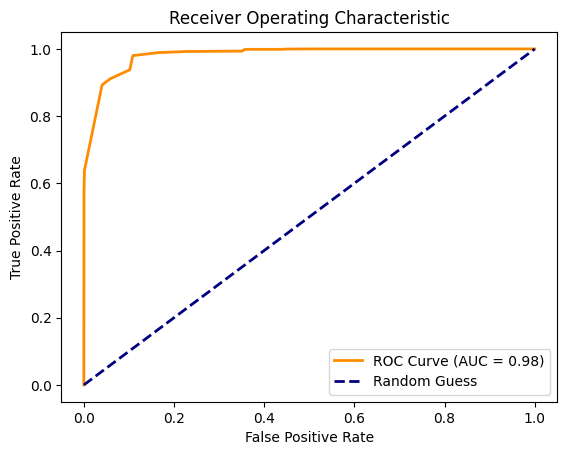

In [43]:
filtered_df["TPs"] = (filtered_df["GROUP"] == "pathogenic").astype(int)
auc_roc = roc_auc_score(filtered_df["TPs"], filtered_df["COMBINED_SCORE"])

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_df["TPs"], filtered_df["COMBINED_SCORE"])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.savefig("roc_combined_score.png")
plt.show()

In [156]:
print(filtered_df.groupby("GROUP")["TPs"].value_counts())

GROUP       TPs
benign      0      2203
pathogenic  1      3230
Name: count, dtype: int64


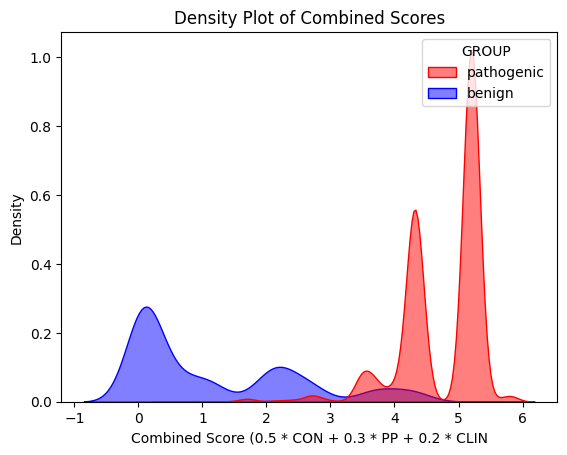

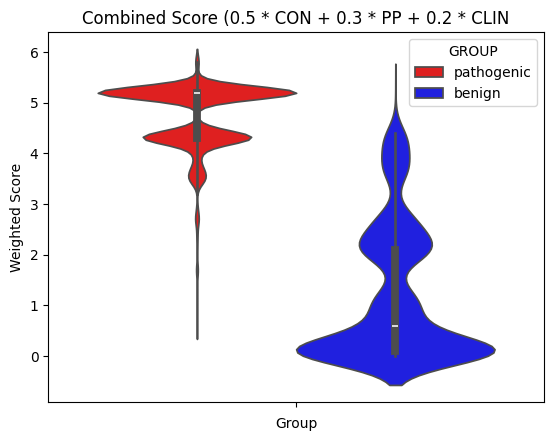

In [27]:
sns.kdeplot(data=filtered_df, x="COMBINED_SCORE", hue="GROUP", fill=True, alpha=0.5, palette={"benign": "blue", "pathogenic": "red"})
plt.title("Density Plot of Combined Scores")
plt.xlabel("Combined Score (0.5 * CON + 0.3 * PP + 0.2 * CLIN")
plt.ylabel("Density")
plt.savefig("density_combined_score.png")
plt.show()

sns.violinplot(hue="GROUP", y="COMBINED_SCORE", data=filtered_df, palette={"benign": "blue", "pathogenic": "red"})
plt.title("Combined Score (0.5 * CON + 0.3 * PP + 0.2 * CLIN")
plt.ylabel("Weighted Score")
plt.xlabel("Group")
plt.savefig("violiin_combined_score.png")
plt.show()


In [30]:
# Reweight 
df = filtered_df.copy()

# Initial weights
weights = {
    "AF": 1.4,
    "CON": 1.3,
    "PP": 1.2,
    "CLIN": 1.1  # Adjust as needed
}
calibrated_weights = {
    "AF": 0.2,
    "CON": 0.3,
    "PP": 0.4,
    "CLIN": 0.1  # Adjust as needed
}

# Compute the initial weighted score
df["WEIGHTED_SCORE"] = (
    calibrated_weights["AF"] * df["AF"] +
    calibrated_weights["CON"] * df["CON"] +
    calibrated_weights["PP"] * df["PP"] +
    calibrated_weights["CLIN"] * df["CLIN"]
)

# Binary group (0 = benign, 1 = pathogenic)
df["TPs"] = (df["GROUP"] == "pathogenic").astype(int)

# AUC-ROC
auc = roc_auc_score(df["TPs"], df["WEIGHTED_SCORE"])
print(f"AUC-ROC: {auc:.3f}")

# KS Test
pathogenic_scores = df.loc[df["GROUP"] == "pathogenic", "WEIGHTED_SCORE"]
benign_scores = df.loc[df["GROUP"] == "benign", "WEIGHTED_SCORE"]
ks_stat, ks_pval = ks_2samp(pathogenic_scores, benign_scores)
print(f"KS Statistic: {ks_stat:.3f}, P-value: {ks_pval:.3f}")

sns.kdeplot(data=df, x="WEIGHTED_SCORE", hue="GROUP", fill=True, alpha=0.5, palette={"benign": "blue", "pathogenic": "red"})
plt.title("Density Plot of Weighted Scores")
plt.xlabel("Weighted Score")
plt.ylabel("Density")
plt.savefig("density_plot_weighted_scores.png")
plt.show()

sns.boxplot(hue="GROUP", y="WEIGHTED_SCORE", data=df, palette={"benign": "blue", "pathogenic": "red"})
plt.title("Boxplot of Weighted Scores by Group")
plt.ylabel("Weighted Score")
plt.xlabel("Group")
plt.savefig("boxplot_weighted_scores.png")
plt.show

AUC-ROC: 0.988


NameError: name 'ks_2samp' is not defined

In [22]:
# Grouped statistics
summary_stats = df.groupby("GROUP")["WEIGHTED_SCORE"].describe()
print(summary_stats)

NameError: name 'df' is not defined

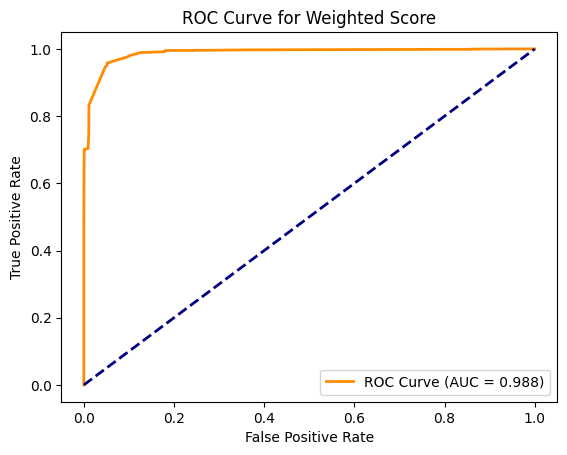

In [245]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(df["TPs"], df["WEIGHTED_SCORE"])

# Plot ROC curve
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.3f})", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Weighted Score")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Automate Reweighting - adjust weights and compute metrics for each iteration

In [239]:
def evaluate_weights(df, weights):
    # Compute weighted score
    df["WEIGHTED_SCORE"] = (
        weights["AF"] * df["AF"] +
        weights["CON"] * df["CON"] +
        weights["PP"] * df["PP"] +
        weights["CLIN"] * df["CLIN"]
    )

    # Compute metrics
    auc = roc_auc_score(df["TPs"], df["WEIGHTED_SCORE"])
    pathogenic_scores = df.loc[df["GROUP"] == "pathogenic", "WEIGHTED_SCORE"]
    benign_scores = df.loc[df["GROUP"] == "benign", "WEIGHTED_SCORE"]
    ks_stat, ks_pval = ks_2samp(pathogenic_scores, benign_scores)

    return {
        "weights": weights,
        "AUC-ROC": auc,
        "KS Statistic": ks_stat,
        "KS P-value": ks_pval
    }

In [243]:
calibrated_weights = {
    "AF": 0.2,
    "CON": 0.3,
    "PP": 0.4,
    "CLIN": 0.1  # Adjust as needed
}

evaluate_weights(df, calibrated_weights)

{'weights': {'AF': 0.2, 'CON': 0.3, 'PP': 0.4, 'CLIN': 0.1},
 'AUC-ROC': 0.9882327644964859,
 'KS Statistic': 0.9067663150024804,
 'KS P-value': 0.0}

In [242]:
# Iterate Over Weight Combinations - adjust weight combinations
weight_combinations = [
    {"AF": 0.4, "CON": 0.3, "PP": 0.2, "CLIN": 0.1},
    {"AF": 0.3, "CON": 0.4, "PP": 0.2, "CLIN": 0.1},
    {"AF": 0.2, "CON": 0.3, "PP": 0.4, "CLIN": 0.1},
]

# Evaluate each weight combination
results = []
for weights in weight_combinations:
    result = evaluate_weights(df, weights)
    results.append(result)

# Print results
for res in results:
    print(res)

{'weights': {'AF': 0.4, 'CON': 0.3, 'PP': 0.2, 'CLIN': 0.1}, 'AUC-ROC': 0.9837413518576553, 'KS Statistic': 0.8914397619907556, 'KS P-value': 0.0}
{'weights': {'AF': 0.3, 'CON': 0.4, 'PP': 0.2, 'CLIN': 0.1}, 'AUC-ROC': 0.9866261037228996, 'KS Statistic': 0.8886324446399435, 'KS P-value': 0.0}
{'weights': {'AF': 0.2, 'CON': 0.3, 'PP': 0.4, 'CLIN': 0.1}, 'AUC-ROC': 0.9882327644964859, 'KS Statistic': 0.9067663150024804, 'KS P-value': 0.0}
